In [202]:
import pandas as pd
import os
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [203]:
import pickle

data_file = "../data/data-v1.001.pkl"
with open (data_file, 'rb') as fin:
    idx, iidx, cascades, innovs = pickle.load (fin)
    
citations_file = "../data/venue_citations.pkl"
with open (citations_file, 'rb') as fin:
    citations = pickle.load (fin)

##### 1. Does initialization of parameters affect convergence?

In [204]:
DIR = "../data/randomization/003/" #directory contains 100 runs with random initialization. 

from scipy.optimize import minimize
runs = 100

results = list ()
for i in range (0+1, runs+1):
    filename = os.path.join (DIR, f'params-v1.001.{i:03}.pkl')
    with open (filename, "rb") as fin:
        result = pickle.load (fin)
        results.append (result)

# check if the optimizer stops on convergence in all the runs 
print (all([result.success for result in results]))
print (sum([result.success for result in results]))

False
76


Good! All the runs converge. Let's plot a histogram to see if they converge at the same value.

In [208]:
failed_results = [result for result in results if not result.success]
print(failed_results[0])

      fun: -420.5746415441754
 hess_inv: <52x52 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.03301546e-01,  3.60500965e-02, -2.07592166e-02, -1.25493217e-01,
        2.41698218e-02,  4.31441552e-02,  6.20843821e-02,  3.00872216e-02,
        4.06708978e-01,  1.04728315e-01,  3.87672117e-03, -1.12640919e-01,
       -1.92244443e-02,  4.16449097e+00, -3.12695647e-02, -5.02723197e-02,
        9.46943146e-01, -1.63782943e-01,  1.66494373e-02, -6.29825078e-03,
       -1.92756032e-02, -1.30739863e-04,  7.08666907e-02, -1.96791916e-01,
        6.64783780e-02,  2.87576540e-01,  1.27848807e+00, -1.73884018e-02,
       -6.38351591e-03,  7.14010189e-02, -3.49473341e-02,  5.09032819e-02,
        5.92308425e-02, -8.43783710e-02, -1.65016445e-02, -1.54841473e-01,
       -4.03019838e-03,  4.45368187e-02, -1.40613565e-01, -3.16163098e-02,
       -3.42822661e-02,  2.34422261e-02,  4.93569132e+00, -3.05135474e-02,
        3.28952867e-02,  2.05625383e-01, -1.28068223e-02,  6.16682883e-01,
 

Mean over 76 runs: 420.4307747471959
Std over 76 runs: 0.45907013392910906


(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 75.]),
 array([416.47858866, 416.88858675, 417.29858485, 417.70858294,
        418.11858103, 418.52857912, 418.93857721, 419.3485753 ,
        419.75857339, 420.16857149, 420.57856958]),
 <a list of 10 Patch objects>)

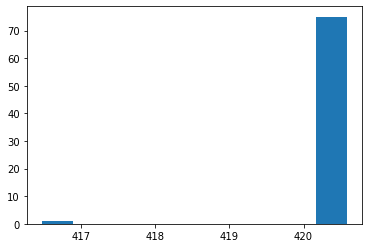

In [209]:
print (f'Mean over {sum([result.success for result in results])} runs: {np.mean ([-result.fun for result in results if result.success])}')
print (f'Std over {sum([result.success for result in results])} runs: {np.std ([-result.fun for result in results if result.success])}')
plt.hist([-result.fun for result in results if result.success])

They mostly all converge to the same value irrespective of the initialization. But let's see if the parameters across the different runs are also similar. 

In [210]:
def plot_histograms (dist, key, runs):
    _ = dist.plot.hist(subplots=True, legend=True, layout=(13, 1), figsize=(5,15), grid=True, bins=20)
    fig = plt.gcf()
    _ = fig.suptitle(f'Distribution of {key} over {runs} runs', fontsize=12)

In [211]:
def get_key_distribution (results, index, idx, dims):
    df = pd.DataFrame ([result.x[index*dims:(index+1)*dims].tolist() for result in results if result.success], 
                       columns=[key for key, _ in sorted (idx.items(), key=lambda x:x[1])])
    return df

In [212]:
dims = len (idx)
params = {"baseline": 0, "transmission": 1, "reception": 2, "self-excitation": 3}

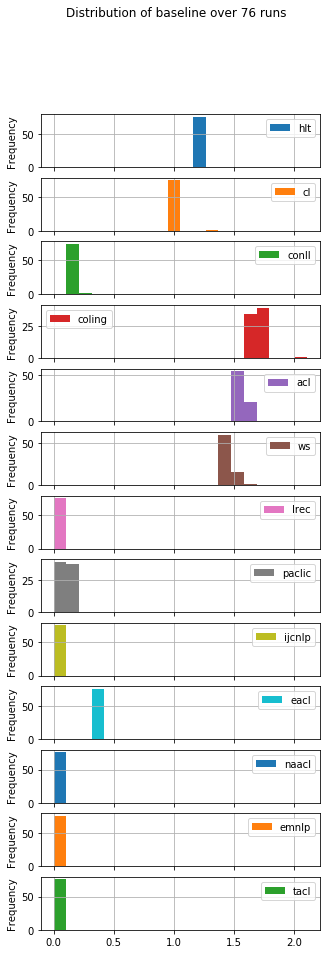

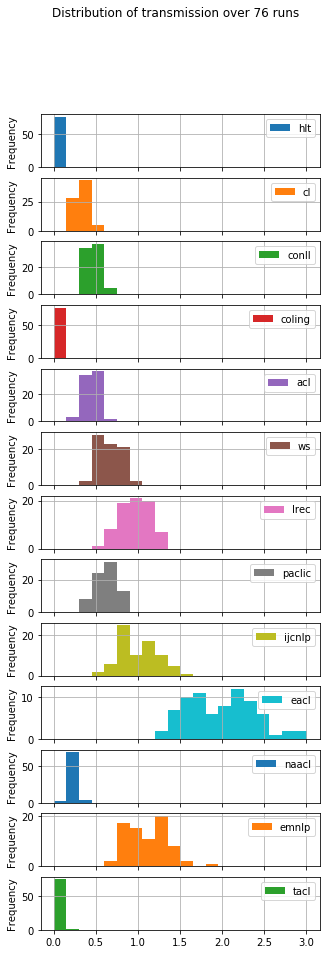

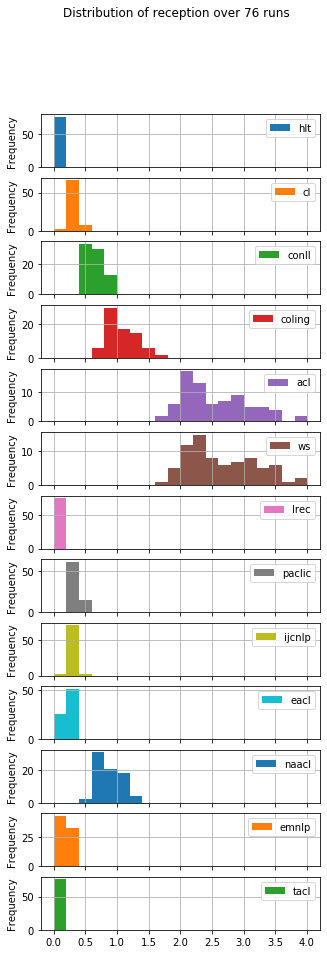

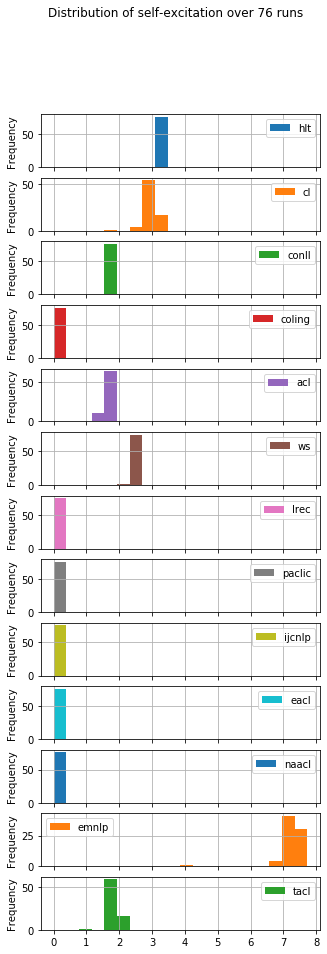

In [213]:
keys = ["baseline", "transmission", "reception", "self-excitation"]
dists = dict ()
for key in keys:
    params_dist = get_key_distribution (results, params[key], idx, dims)
    dists[key] = params_dist
    plot_histograms (dists[key], key, sum([result.success for result in results]))

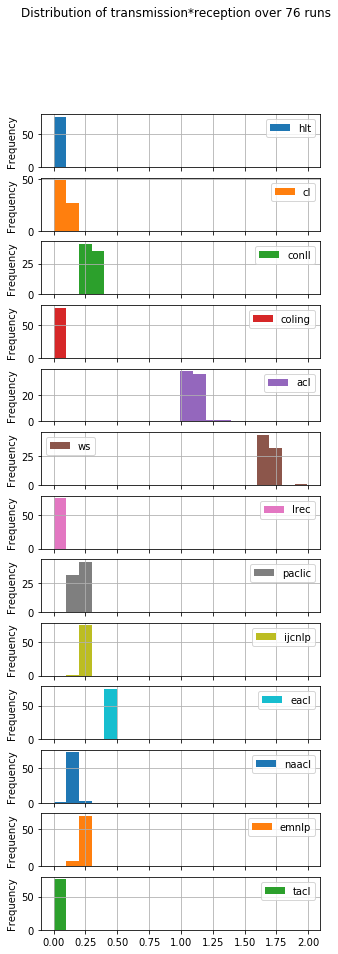

In [214]:
params_dist = pd.DataFrame ([(result.x[params["transmission"]*dims:(params["transmission"]+1)*dims] * result.x[params["reception"]*dims:(params["reception"]+1)*dims]).tolist() for result in results if result.success],
                           columns=[key for key, _ in sorted (idx.items(), key=lambda x:x[1])])
plot_histograms (params_dist, "transmission*reception", sum([result.success for result in results]))

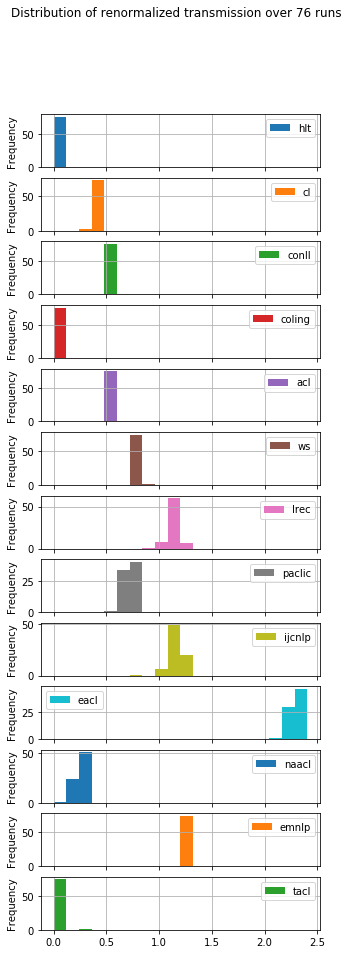

In [215]:
renormalized_transmission_dist = pd.DataFrame ([np.sqrt((np.linalg.norm(result.x[params['reception']*dims:(params['reception']+1)*dims])/np.linalg.norm(result.x[params['transmission']*dims:(params['transmission']+1)*dims]))) * result.x[params['transmission']*dims:(params['transmission']+1)*dims] 
                                                for result in results if result.success],
                                              columns=[key for key, _ in sorted (idx.items(), key=lambda x:x[1])])

plot_histograms (renormalized_transmission_dist, "renormalized transmission", sum([result.success for result in results]))

In [221]:
print (renormalized_transmission_dist)
print(renormalized_transmission_dist.mean(axis=0))
print(renormalized_transmission_dist.std(axis=0))

    hlt        cl     conll  coling       acl        ws      lrec    paclic  \
0   0.0  0.398818  0.548172     0.0  0.507341  0.763011  1.245348  0.734768   
1   0.0  0.377046  0.536742     0.0  0.493042  0.747248  1.091895  0.708709   
2   0.0  0.393756  0.549646     0.0  0.530972  0.761443  1.111160  0.721054   
3   0.0  0.393013  0.562433     0.0  0.505205  0.745972  1.084123  0.758233   
4   0.0  0.373958  0.518457     0.0  0.524080  0.788531  1.029968  0.721633   
..  ...       ...       ...     ...       ...       ...       ...       ...   
71  0.0  0.375694  0.485571     0.0  0.523012  0.774599  1.085153  0.737475   
72  0.0  0.395725  0.558393     0.0  0.509679  0.763524  1.108932  0.688823   
73  0.0  0.348290  0.525064     0.0  0.512090  0.755403  1.116481  0.713329   
74  0.0  0.386385  0.539225     0.0  0.509114  0.776947  1.156362  0.754603   
75  0.0  0.362043  0.534639     0.0  0.512168  0.772356  1.124035  0.740468   

      ijcnlp      eacl     naacl     emnlp  tacl  


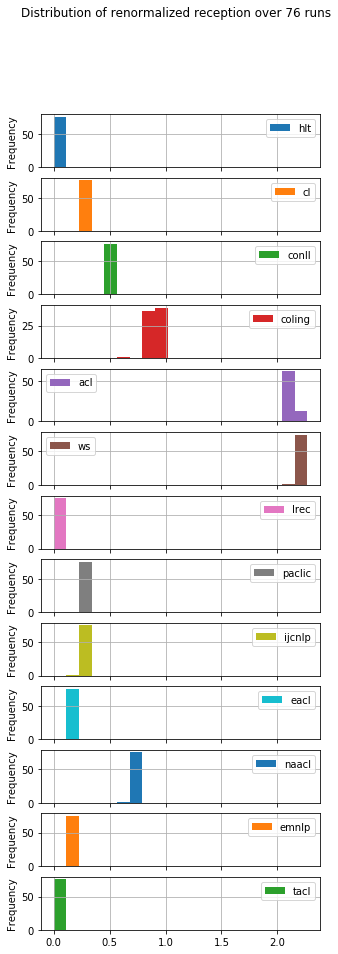

In [222]:
renormalized_reception_dist = pd.DataFrame ([np.sqrt((np.linalg.norm(result.x[params['transmission']*dims:(params['transmission']+1)*dims])/np.linalg.norm(result.x[params['reception']*dims:(params['reception']+1)*dims]))) * result.x[params['reception']*dims:(params['reception']+1)*dims] 
                                                for result in results if result.success],
                                              columns=[key for key, _ in sorted (idx.items(), key=lambda x:x[1])])

plot_histograms (renormalized_reception_dist, "renormalized reception", sum([result.success for result in results]))

##### Calculate the CI for each parameter.

In [223]:
DIR = "../data/randomization/004/" #directory contains 100 runs on randomized cascades.

from scipy.optimize import minimize
runs = 100

results = list ()
for i in range (0+1, runs+1):
    filename = os.path.join (DIR, f'params-v1.001.{i:03}.pkl')
    with open (filename, "rb") as fin:
        result = pickle.load (fin)
        results.append (result)

# check if the optimizer stops on convergence in all the runs 
print (all([result.success for result in results]))
print (sum([result.success for result in results]))

False
80


In [224]:
failed_results = [result for result in results if not result.success]
print(failed_results[0])

      fun: -424.74930883401447
 hess_inv: <52x52 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.09940857e-01, -2.10411598e-01,  3.19744231e-02,  2.26634712e-01,
        9.82879561e-02,  3.73120204e-02,  6.60804744e-02,  7.84382337e-02,
       -4.09443146e-02,  5.48425305e-02, -3.40151018e-02,  1.36202516e-01,
       -8.99262886e-03,  6.04384240e+00,  1.25146471e-01,  1.28289911e-01,
        5.38228164e+00,  1.50168944e-01, -1.07149844e-01,  1.53011115e-01,
        4.63728614e-02, -4.99085221e-03, -5.92876862e-03,  1.75307946e+00,
        1.24316558e-02,  8.94317509e-02,  2.50902872e+00, -8.86757334e-03,
       -1.72417459e-01, -1.59872117e-01,  1.22895472e-01,  1.80818916e-02,
        5.14995691e-01, -7.16227078e-02,  3.53793439e-02,  2.37611175e-01,
        1.47122138e-01,  3.42595286e-02, -9.32999455e-01, -2.28965293e-02,
        1.76584082e-01, -2.35559127e-02,  4.96510779e+00, -3.36342511e-02,
       -1.68313364e-02,  2.01310968e-01, -3.50439676e-02,  6.61071908e-01,


Mean over 80 runs: 422.7159514143206
Std over 80 runs: 2.4350045015847948


(array([ 1.,  1.,  0.,  0.,  0.,  1.,  5., 18., 37., 17.]),
 array([408.9479253 , 410.64784849, 412.34777167, 414.04769486,
        415.74761804, 417.44754123, 419.14746442, 420.8473876 ,
        422.54731079, 424.24723397, 425.94715716]),
 <a list of 10 Patch objects>)

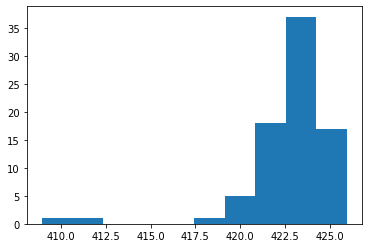

In [225]:
print (f'Mean over {sum([result.success for result in results])} runs: {np.mean ([-result.fun for result in results if result.success])}')
print (f'Std over {sum([result.success for result in results])} runs: {np.std ([-result.fun for result in results if result.success])}')
plt.hist([-result.fun for result in results if result.success])

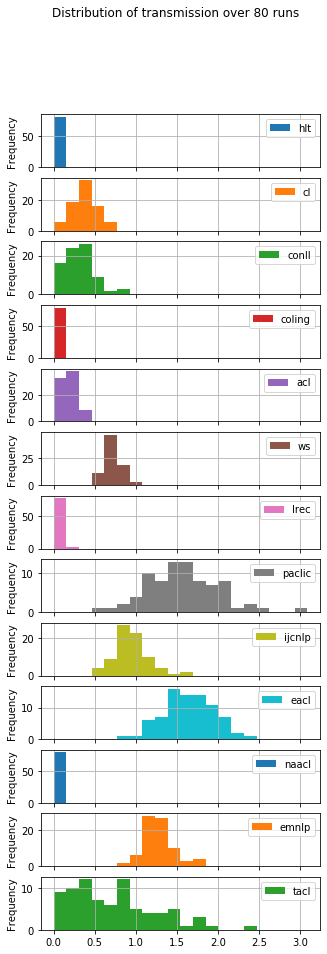

In [226]:
params_dist = get_key_distribution (results, params["transmission"], idx, dims)
plot_histograms (params_dist, "transmission", sum([result.success for result in results]))

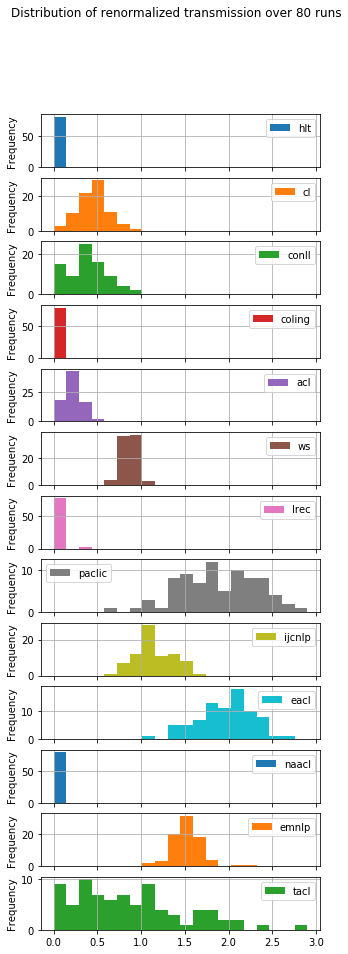

In [227]:
renormalized_transmission_dist = pd.DataFrame ([np.sqrt((np.linalg.norm(result.x[params['reception']*dims:(params['reception']+1)*dims])/np.linalg.norm(result.x[params['transmission']*dims:(params['transmission']+1)*dims]))) * result.x[params['transmission']*dims:(params['transmission']+1)*dims] 
                                                for result in results if result.success],
                                              columns=[key for key, _ in sorted (idx.items(), key=lambda x:x[1])])

plot_histograms (renormalized_transmission_dist, "renormalized transmission", sum([result.success for result in results]))

In [228]:
print (renormalized_transmission_dist)
print (renormalized_transmission_dist.mean(axis=0))
print (renormalized_transmission_dist.std(axis=0))

    hlt        cl     conll  coling       acl        ws  lrec    paclic  \
0   0.0  0.453139  0.586134     0.0  0.047758  0.891548   0.0  1.369065   
1   0.0  0.550679  0.304627     0.0  0.000000  0.821701   0.0  2.327245   
2   0.0  0.370878  0.292671     0.0  0.111807  0.867665   0.0  1.787993   
3   0.0  0.262780  0.000000     0.0  0.356831  0.935195   0.0  1.729615   
4   0.0  0.283270  0.181179     0.0  0.285558  0.846740   0.0  2.339537   
..  ...       ...       ...     ...       ...       ...   ...       ...   
75  0.0  0.384975  0.397256     0.0  0.229107  0.872122   0.0  1.876538   
76  0.0  0.340402  0.747862     0.0  0.034056  0.619981   0.0  2.898839   
77  0.0  0.270471  0.383739     0.0  0.256095  0.914658   0.0  1.429392   
78  0.0  0.524033  0.500383     0.0  0.243883  1.004951   0.0  0.892932   
79  0.0  0.563397  0.495038     0.0  0.369014  0.861763   0.0  1.592039   

      ijcnlp      eacl  naacl     emnlp      tacl  
0   0.862054  2.219339    0.0  1.470698  1.7611